#Analisis Pendeteksian Ekspresi Gen dalam Klasifikasi Jenis Kanker Acute Myeloid Leukemia (AML) dan Acute Lymphoblastic Leukemia (ALL) Menggunakan Machine Learning

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


## Load all the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import ndimage
import seaborn as sns

## Input Data

In [ ]:
!pip install GEOparse

from google.colab import output
import GEOparse
output.clear()

In [ ]:
gse_aml = GEOparse.get_GEO(geo= "GSE18700", destdir="./GEO")
output.clear()
sample_id = list(gse_aml.gsms.keys())[0]
sample = gse_aml.gsms[sample_id]
print(sample.table.head())

              ID_REF     VALUE
0  MSPI0406S00000183 -3.463852
1  MSPI0406S00000238 -2.631708
2  MSPI0406S00000239 -0.529217
3  MSPI0406S00000300  2.016071
4  MSPI0406S00000301  1.445680


In [ ]:
gse_all = GEOparse.get_GEO(geo= "GSE34937", destdir="./GEO")
output.clear()
sample_id = list(gse_all.gsms.keys())[0]
sample = gse_all.gsms[sample_id]
print(sample.table.head())

              ID_REF     VALUE
0  MSPI0406S00000183 -4.297433
1  MSPI0406S00000238 -3.050146
2  MSPI0406S00000239 -0.268884
3  MSPI0406S00000300  1.814920
4  MSPI0406S00000301  1.870343


In [ ]:
def parse_gsm(gsm):
    return gsm.table.set_index("ID_REF")["VALUE"]

In [ ]:
data_aml = pd.DataFrame({gsm_id: parse_gsm(gsm) for gsm_id, gsm in gse_aml.gsms.items()})
print(data_aml.shape)
data_aml.head()

(25626, 352)


,GSM435212,GSM435213,GSM435214,GSM435215,GSM435216,GSM435217,GSM435218,GSM435219,GSM464737,GSM464738,...,GSM465071,GSM465072,GSM465073,GSM465074,GSM465075,GSM465076,GSM465077,GSM465078,GSM465079,GSM465080
ID_REF,,,,,,,,,,,,,,,,,,,,,
MSPI0406S00000183,-3.463852,-3.736712,-3.764950,-3.666404,-3.491218,-3.192682,-4.134549,-3.610680,-3.351254,-2.921540,...,-2.153494,-3.781905,-1.967586,-1.841479,-3.649261,-0.966969,-1.613782,-2.470832,-2.114214,-1.926117
MSPI0406S00000238,-2.631708,-3.115822,-3.272682,-3.112236,-2.615526,-2.420408,-3.342289,-3.052628,-2.867341,-3.177293,...,-3.160914,-2.948576,-2.316578,-2.178052,-3.027265,-2.189092,-1.977851,-2.809755,-2.339937,-2.321492
MSPI0406S00000239,-0.529217,-0.953496,-0.930743,-1.225400,-0.561025,-0.603819,-1.688884,-1.205992,-1.192315,-1.787906,...,-0.767818,-0.929756,-0.604661,-0.728020,-0.768075,-0.275744,-0.338296,-1.757441,-0.778411,-0.593651
MSPI0406S00000300,2.016071,1.951845,1.635517,1.764377,1.787644,1.785402,1.378451,1.494519,1.583461,1.516575,...,3.087630,0.789689,2.542963,2.517738,1.703756,1.408409,1.319890,1.475934,1.178220,2.422106
MSPI0406S00000301,1.445680,1.531560,1.365639,1.296186,1.411915,1.292919,0.859615,1.130333,1.166713,1.398489,...,3.292677,1.046205,3.013979,2.796678,1.201718,1.698132,1.972224,2.125208,1.232881,2.522435


In [ ]:
data_all = pd.DataFrame({gsm_id: parse_gsm(gsm) for gsm_id, gsm in gse_all.gsms.items()})
print(data_all.shape)
data_all.head()

(25626, 227)


,GSM857848,GSM857849,GSM857850,GSM857851,GSM857852,GSM857853,GSM857854,GSM857855,GSM857856,GSM857857,...,GSM858065,GSM858066,GSM858067,GSM858068,GSM858069,GSM858070,GSM858071,GSM858072,GSM858073,GSM858074
ID_REF,,,,,,,,,,,,,,,,,,,,,
MSPI0406S00000183,-4.297433,-2.563743,-1.517471,-1.357523,-3.827570,-3.481171,-1.760935,-3.230552,-3.605320,-2.676378,...,-3.628542,-3.453310,-3.290704,-3.359157,-3.640209,-3.166321,-3.565753,-3.478810,-3.623578,-3.154063
MSPI0406S00000238,-3.050146,-3.040467,-2.156924,-1.959459,-2.526764,0.263707,-2.487403,-2.141378,-2.650291,-1.835392,...,-2.807019,-2.729460,-2.752642,-2.851963,-2.829398,-2.513177,-3.199932,-2.680045,-3.008967,-2.504287
MSPI0406S00000239,-0.268884,-0.454395,1.388806,-0.408198,-1.011952,2.431605,-0.736910,-1.076483,0.070313,1.029728,...,-1.157598,-1.494695,-1.218885,-1.438973,-0.938478,-1.729547,-1.678370,-1.614531,-1.357584,-1.464172
MSPI0406S00000300,1.814920,0.758295,3.314691,2.896073,2.538577,2.851521,3.196553,2.832572,1.314983,0.751476,...,1.457669,1.462493,1.297752,1.245954,1.432139,1.107198,1.231089,0.880292,1.364956,1.037012
MSPI0406S00000301,1.870343,0.501178,2.763913,2.460173,2.896960,2.462976,2.691938,2.447820,1.554438,-0.206791,...,0.446705,1.394906,1.198741,1.332467,1.475642,1.352860,1.431488,1.121387,1.526743,1.470350


In [ ]:
data_aml = data_aml.T
data_all = data_all.T

In [ ]:
data_aml["cancer"] = 0 #aml
data_all["cancer"] = 1 #all

In [ ]:
print(data_all.isna().sum().max())
print(data_aml.isna().sum().max())

227
0


In [ ]:
null_counts = data_all.isna().sum()

sorted_null_columns = null_counts[null_counts > 0].sort_values(ascending=False)

null_df = sorted_null_columns.reset_index()
null_df.columns = ['Column', 'Num_of_NaN']

total_rows = len(data_all)
null_df['Percentage_of_NaN'] = (null_df['Num_of_NaN'] / total_rows) * 100
display(null_df)
for index, row in null_df.iterrows():
    column_name = row['Column']
    percentage_nan = row['Percentage_of_NaN']
    if percentage_nan > 10:
        data_all.drop(columns=[column_name], inplace=True)
    else:
        mean_value = data_all[column_name].mean()
        data_all[column_name].fillna(mean_value, inplace=True)

,Column,Num_of_NaN,Percentage_of_NaN
0,MSPI0406S00687785,227,100.000000
1,MSPI0406S00834301,227,100.000000
2,MSPI0406S00030374,227,100.000000
3,MSPI0406S00564999,227,100.000000
4,MSPI0406S00275013,227,100.000000
...,...,...,...
11421,MSPI0406S00799381,1,0.440529
11422,MSPI0406S00799390,1,0.440529
11423,MSPI0406S00799411,1,0.440529
11424,MSPI0406S00152390,1,0.440529


In [ ]:
#check for nulls
print(data_all.isna().sum().max())
print(data_aml.isna().sum().max())

0
0


In [ ]:
print(data_all.shape)
print(data_aml.shape)

(227, 20329)
(352, 25627)


In [ ]:
full_data = data_all

In [ ]:
common_columns = full_data.columns.intersection(data_aml.columns)
filtered_data_aml = data_aml[common_columns]
full_data = full_data.append(filtered_data_aml)
output.clear()
print(full_data.shape)
full_data.head()

(579, 20329)


ID_REF,MSPI0406S00000183,MSPI0406S00000238,MSPI0406S00000239,MSPI0406S00000300,MSPI0406S00000301,MSPI0406S00000321,MSPI0406S00000352,MSPI0406S00000353,MSPI0406S00000360,MSPI0406S00000361,...,MSPI0406S01020598,MSPI0406S01020606,MSPI0406S01020607,MSPI0406S01020614,MSPI0406S01020689,MSPI0406S01020926,MSPI0406S01023761,MSPI0406S01024248,MSPI0406S01025454,cancer
GSM857848,-4.297433,-3.050146,-0.268884,1.814920,1.870343,0.903858,1.541737,0.256756,-0.970197,-1.134228,...,0.569762,1.203442,-0.630059,2.454584,-0.213808,0.935094,0.007338,2.524589,2.209856,1
GSM857849,-2.563743,-3.040467,-0.454395,0.758295,0.501178,-0.145286,1.541737,0.089666,-0.356803,0.119034,...,-2.430646,0.341156,-1.079506,1.208634,-0.665450,0.125068,2.871248,1.409833,-0.032462,1
GSM857850,-1.517471,-2.156924,1.388806,3.314691,2.763913,1.173139,0.842698,-0.057508,-0.651638,-1.943087,...,-1.224464,2.140055,-1.000740,3.344341,-1.352667,1.100163,-0.565422,0.323634,0.362297,1
GSM857851,-1.357523,-1.959459,-0.408198,2.896073,2.460173,0.997481,0.470382,-0.384133,0.736896,0.109110,...,-1.495143,0.356272,-1.450194,-0.375401,-1.143287,0.507122,0.903126,2.144944,2.256651,1
GSM857852,-3.827570,-2.526764,-1.011952,2.538577,2.896960,2.937755,2.153009,0.838426,-0.115172,-0.410394,...,-1.557496,2.206684,0.152901,2.329189,-2.142283,2.391374,0.921138,-0.381883,0.379807,1


In [ ]:
patients = [str(i) for i in range(1, len(full_data)+1, 1)]
full_data["patient"] = pd.to_numeric(patients)

Text(0.5, 1.0, 'Class Distributions \n (0: AML || 1: ALL)')

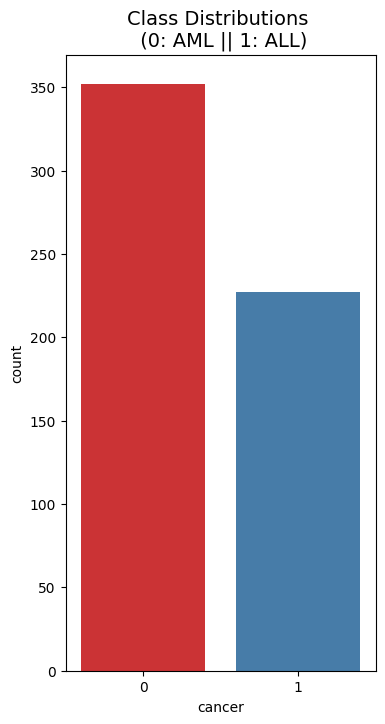

In [ ]:
plt.figure(figsize=(4,8))
colors = ["AML", "ALL"]
sns.countplot(x='cancer', data=full_data, palette = "Set1")
plt.title('Class Distributions \n (0: AML || 1: ALL)', fontsize=14)

In [ ]:
X, y = full_data.drop(columns=["cancer","patient"]), full_data["cancer"]

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 40)

In [ ]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Dimentionality reduction using Principal Component Analysis(PCA)

181 features explain around 90% of the variance. From 7129 features to 181, not too bad.


<BarContainer object of 181 artists>

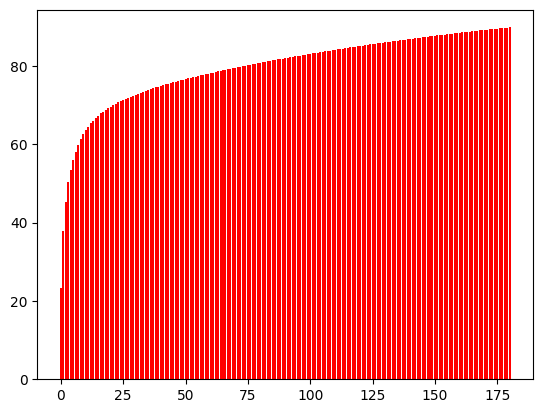

In [ ]:
pca = PCA()
pca.fit_transform(X_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp,color = 'r')

##Hyperparameter optimization

###Hyperprameter optimization for SVM

In [ ]:
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

search = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=1)
search.fit(X_train_pca, y_train)

best_accuracy = search.best_score_
best_parameters = search.best_params_

best_svc = search.best_estimator_
best_svc

Fitting 5 folds for each of 40 candidates, totalling 200 fits


SVC(C=1, kernel='linear')

The accuracy of SVM is 0.993103448275862

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.98      1.00      0.99        57

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

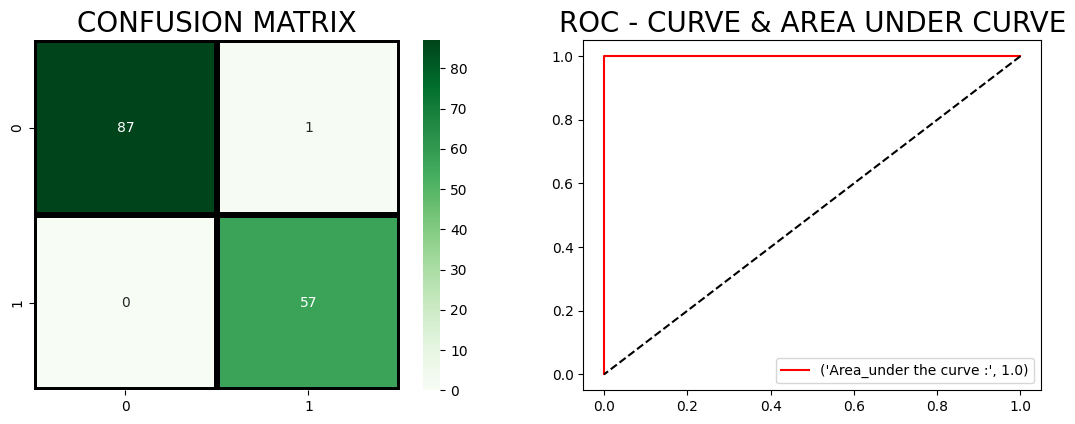

In [ ]:
svc_model = SVC(C=1, kernel='linear',probability=True)

svc_model.fit(X_train_pca, y_train)


prediction=svc_model.predict(X_test_pca)

acc_svc = accuracy_score(prediction,y_test)
print('The accuracy of SVM is', acc_svc)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

predicting_probabilites = svc_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)